<a href="https://colab.research.google.com/github/SampadSikder/DP-Protocols/blob/main/DiffStats_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialize

In [3]:
import argparse
import math
import matplotlib.pyplot as plt

In [4]:
import random
from multiprocessing import Pool
import numpy as np
import xxhash
import pandas as pd
from sklearn.preprocessing import LabelEncoder


In [5]:
domain = 0
epsilon = 0.0
n = 0
g = 0
X = []
Y = []
Y_Nattack = []
sample = []
REAL_DIST = []
ESTIMATE_DIST = []
User_Seed = []
User_Seed_Nattack = []
p = 0.0
q = 0.0
Gain = 0
splits = 0
h_ao = 0
global Gain, ESTIMATE_DIST, Y

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Parameter loading

In [7]:
global ESTIMATE_DIST, REAL_DIST, n, p, q, epsilon, domain, User_Seed, User_Seed_Nattack, target_set_size, vswhat, g, splits, h_ao

In [41]:
epsilon = 0.7
splits = 2
h_ao = 1 # for adaptive attack
g = int(round(math.exp(epsilon))) + 1
dataset = 'zipf'
ratio = 0.05
target_set_size = 50

In [42]:
if dataset == 'zipf':
        #n = 1000000
        n = 30000
        domain = 1024
if dataset == 'emoji':
        n = 218477
        #n = 100000
        domain = 1496
if dataset == 'fire':
        #n = 723090
        n = 30000
        domain = 296

In [43]:
User_Seed = np.zeros(n)
User_Seed_Nattack = np.zeros(n)
REAL_DIST = np.zeros(domain)
#REAL_DIST = Counter()
ESTIMATE_DIST = np.zeros(domain)

In [44]:
p = math.exp(epsilon) / (math.exp(epsilon) + g - 1)
q = 1.0 / (math.exp(epsilon) + g - 1)

print('n: ', n)
print('ratio: ', ratio)
print('target_set_size: ', target_set_size)
print('e: ', epsilon)
print('split: ', splits)
print('h_ao: ', h_ao)

n:  30000
ratio:  0.05
target_set_size:  50
e:  0.7
split:  2
h_ao:  1


## Load Dataset

In [45]:
def generate_zipf_dist():
  global REAL_DIST, domain, sample, X
  X = np.load('/content/drive/MyDrive/Purdue Work/Datasets/zipf.npy')
  for i in range(n):
    REAL_DIST[X[i]] += 1



In [46]:
def generate_emoji_dist():
  global X
  data = np.load('/content/drive/MyDrive/Purdue Work/Datasets/emoji.npy')
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1

In [47]:
def generate_fire_dist():
  global X
  values = pd.read_csv("/content/drive/MyDrive/Purdue Work/Datasets/fire.csv")["Unit_ID"]
  #print(np.array(values))
  lf = LabelEncoder().fit(values)
  data = lf.transform(values)
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1

In [48]:
if dataset == 'zipf':
    generate_zipf_dist()
if dataset == 'emoji':
    generate_emoji_dist()
if dataset == 'fire':
    generate_fire_dist()

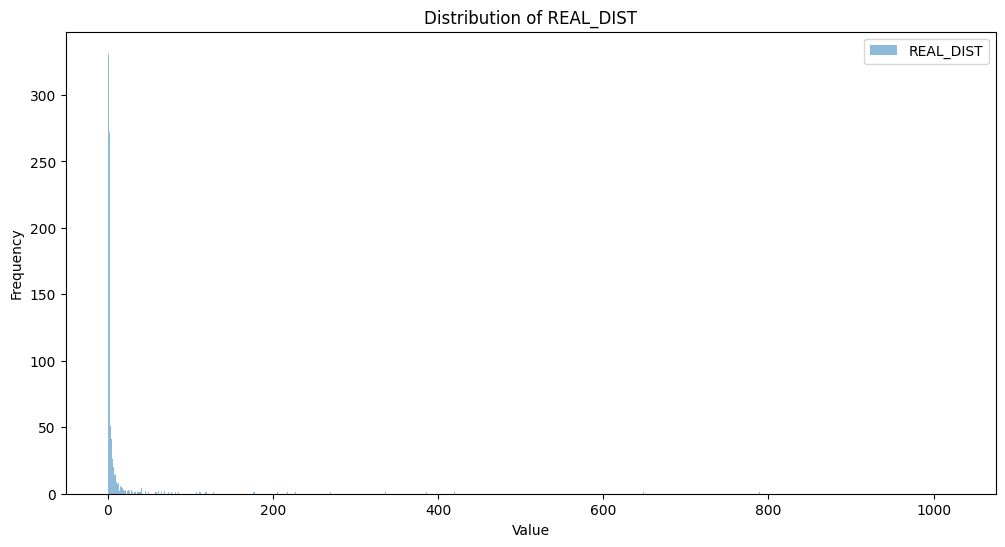

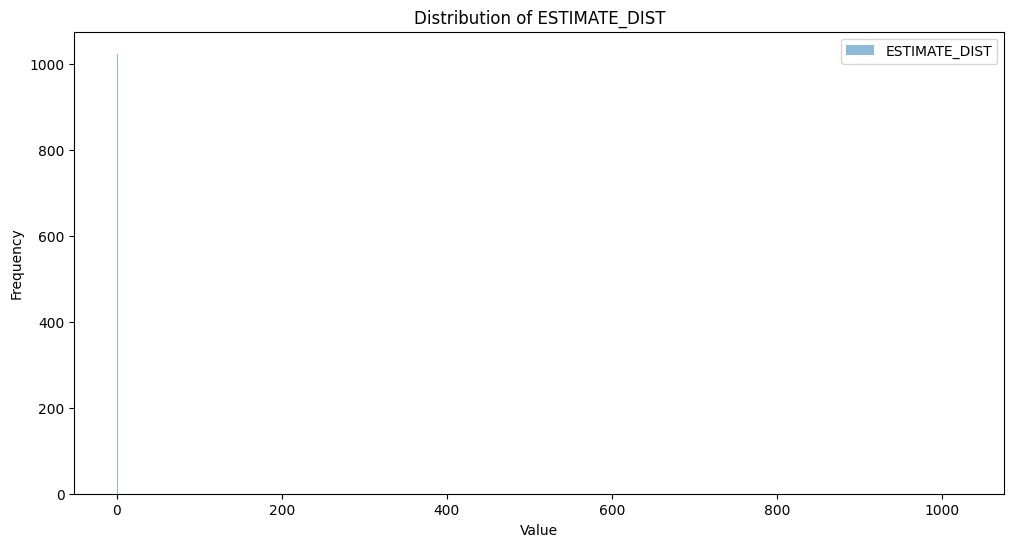

In [49]:
plt.figure(figsize=(12, 6))
plt.hist(REAL_DIST, bins=range(domain + 1), alpha=0.5, label='REAL_DIST')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of REAL_DIST')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(ESTIMATE_DIST, bins=range(domain + 1), alpha=0.5, label='ESTIMATE_DIST')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of ESTIMATE_DIST')
plt.legend()
plt.show()

## Protocols

In [17]:
from tqdm import tqdm
import random
# from mlxtend.preprocessing import TransactionEncoder
# from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
from functools import partial
from multiprocessing import Pool
import math
import scipy.stats as stats
from scipy.stats import binom, chisquare


In [18]:
# APA Attack
def construct_omega(e, d, perturb_method):
    p_binomial = None
    if perturb_method == 'OUE':
        p = 1 / 2
        q = 1 / (math.exp(e) + 1)
        expected_ones = p + (d - 1) * q
        p_binomial = (1 / d) * (p + (d - 1) * q)
    elif perturb_method in ('OLH_User', 'OLH_Server'):
        g = int(round(math.exp(e))) + 1
        p = math.exp(e) / (math.exp(e) + g - 1)
        q = 1 / g
        expected_ones = p + (d - 1) * q
        p_binomial = (1 / d) * (p + (d - 1) * q)
    elif perturb_method in ('HST_Server', 'HST_User'):
        p_binomial = 1 / 2
        p = q = 1 / 2
        expected_ones = d * p_binomial
    k_values = [i for i in range(d)]
    theoretical_pdf = binom.pmf(k_values, d, p_binomial)
    theoretical_pdf /= theoretical_pdf.sum()
    return theoretical_pdf

### OLH

### Attacked OLH

In [19]:
num_samples = 1000000


In [20]:
def uniform_sampling_best_vector(target_set, g, d, m, num_samples):
    best_vector = None
    closest_ones_diff = float('inf')
    max_target_count = 0
    best_score = -float('inf')
    current_target = None
    current_diff = None

    for _ in range(num_samples):
        # Generate uniform samples for binary vectors (0 or 1)
        vector = np.random.binomial(1, 1 / g, size=d)

        # Count the number of 1's in the vector
        ones_count = np.sum(vector)
        ones_diff = abs(ones_count - m)  # Difference between current 1's count and target m

        # Count how many target items map to positions with 1's in the vector
        target_count = sum(1 for item in target_set if vector[item % d] == 1)

        # Calculate the score: target_count - ones_diff
        score = target_count - ones_diff

        # Update the best vector if the score is better
        if score > best_score:
            best_score = score
            best_vector = vector
            current_target = target_count
            current_diff = ones_diff

    return best_vector, current_target, current_diff

In [21]:
def calculate_prob_according_sample_size(num_samples, d, g, h, target_set, splits):

    splits_list = random.sample(list(target_set), splits)
    target_set = splits_list
    user_vectors = []
    p = 1 / g

    mu = d * p
    sigma = np.sqrt(d * p * (1 - p))

    lower_bound = max(0, mu - h)
    upper_bound = min(d, mu + h)

    binom_dist = stats.binom(d, p)
    ratio = (binom_dist.cdf(upper_bound) - binom_dist.cdf(lower_bound - 1))
    ratio = ratio / (2 * h + 1)
    # ratio = 1

    N_effective = num_samples * ratio
    print('N_effective: ', N_effective)

    K_min = 1
    K_max = len(target_set)
    for K in range(K_max, K_min - 1, -1):
        prob = (p) ** K * N_effective
        if prob < 1:
            K_max = K
        else:
            break
    K_min = max(K_max, 1)

    K_values = np.arange(K_min, len(target_set) + 1)
    K_probs = []
    for K in K_values:
        prob = (p) ** K * N_effective
        K_probs.append(prob)
    K_probs = np.array(K_probs)

    K_probs = K_probs / np.sum(K_probs)

    return K_values, K_probs

In [22]:
def process_attacker(i, n, ratio, target_set, g, domain, splits, h_ao, e, K_values, K_probs):
    # Seed the random number generator uniquely for each process
    k = np.random.choice(K_values, p=K_probs)
    random.seed()
    averge_project_hash = int(domain / g)
    if splits < averge_project_hash:
        # Split the target set for each user
        splits_list = random.sample(list(target_set), splits)
        # Gap between average mapping
        num_map = averge_project_hash
        # Remaining set (unused in this snippet but kept for completeness)
        remaining_set = set(range(domain)) - set(target_set)
        # Adaptive gap between average mapping
        #h_ao = 0
        # num_map_AO = random.randint(num_map - h_ao, num_map + h_ao)
        # theoretical APA use the omega_list to replace the num_map_AO num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        omega_probs = construct_omega(e, domain, 'OLH_User')
        num_map_AO = np.random.choice(range(domain), p=omega_probs)
        non_target_ones = num_map_AO - k
        # Each attacker finds their optimal hash function
        '''best_vector, target_map, diff  = uniform_sampling_best_vector(
            splits_list, g, domain, num_map_AO, num_samples)'''
        target_indices = np.random.choice(list(splits_list), size=k, replace=False)
        non_target_indices = list(set(range(domain)) - set(splits_list))
        non_target_selected = np.random.choice(non_target_indices, size=non_target_ones, replace=False)
        vector = np.zeros(domain, dtype=int)
        vector[target_indices] = 1
        vector[non_target_selected] = 1
    else:
        print('splits > averge_project_hash')
        exit(0)
    # Calculate the index in User_Seed to update
    index = int(n * (1 - ratio) + i)
    #print(f'attacker:{i}, target_map:{k}, diff:{num_map_AO - sum(vector)}, h_ao:{h_ao}, splits:{splits}')
    return index, vector

In [23]:
def process_user_seeds(i, User_Seed_noattack, Y_Nattack, domain, g):
    print("Processing index" + str(i))
    local_estimate = np.zeros(domain)
    user_seed = User_Seed_noattack[i]
    for v in range(domain):
        if Y_Nattack[i] == (xxhash.xxh3_64(str(v), seed=int(user_seed)).intdigest() % g):
            local_estimate[v] += 1
    # Apply the correction factor
    local_estimate = local_estimate
    return local_estimate

In [24]:
def find_hash_function(seed_list, target_set, domain_eliminate, g, num_map_AO):
    # log the max projection number
    best_score = -np.inf
    # log the best projection seed
    best_seed = -1
    # log the target mapped
    best_target_mapped = None
    # log the best hash value
    best_hash_value = None
    # log the min gap
    best_gap = None
    for seed in seed_list:
        hash_projection_list = np.zeros(g)
        hash_other_projection_list = np.zeros(g)
        hash_result = None
        for item in target_set:
            hash_result = xxhash.xxh3_64(str(item), seed=seed).intdigest() % g
            hash_projection_list[hash_result] += 1
        for item in domain_eliminate:
            hash_result = xxhash.xxh3_64(str(item), seed=seed).intdigest() % g
            hash_other_projection_list[hash_result] += 1
        score = hash_projection_list - np.abs(num_map_AO - hash_projection_list - hash_other_projection_list)
        current_best_score = np.max(score)
        max_indices = np.where(score == current_best_score)[0]
        current_max_target_mapped = hash_projection_list[max_indices]
        current_untarget_mapped = hash_other_projection_list[max_indices]
        current_hash_value = max_indices
        current_gap = np.abs(num_map_AO - current_max_target_mapped - current_untarget_mapped)
        if current_best_score > best_score:
            best_seed = seed
            best_score = current_best_score
            best_hash_value = current_hash_value
            best_gap = current_gap
            best_target_mapped = current_max_target_mapped
    if best_seed == -1:
        return -1, 0.0, None
    return best_seed, best_gap, best_target_mapped, best_hash_value


In [25]:
def process_attacker_User(i, n, ratio, target_set, g, domain, splits, e, h_ao):
    average_project_hash = int(domain / g)
    vector = np.zeros(domain, dtype=int)
    if splits < average_project_hash:
        # Split the target set for each user
        splits_list = random.sample(list(target_set), splits)
        # Gap between average mapping
        num_map = average_project_hash
        # Remaining set (unused in this snippet but kept for completeness)
        remaining_set = set(range(domain)) - set(target_set)
        # Adaptive gap between average mapping
        num_map_AO = random.randint(num_map - h_ao, num_map + h_ao)
        # theoretical APA use the omega_list to replace the num_map_AO num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        #num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        seed_list = random.sample(range(1, 10000000), num_samples)
        best_seed, best_gap, current_max_target_mapped, best_hash_value = find_hash_function(seed_list, splits_list,
                                                                                             remaining_set, g,
                                                                                             num_map_AO)
    else:
        print('splits > averge_project_hash')
        exit(0)
    # Calculate the index in User_Seed to update
    index = int(n * (1 - ratio) + i)
    for v in range(domain):
        hashed_value = xxhash.xxh3_64(str(v), seed=int(best_seed)).intdigest() % g
        if hashed_value == best_hash_value:
            vector[v] = 1
   # print(f'attacker:{i}, target_map:{current_max_target_mapped}, diff:{best_gap}, h_ao:{h_ao}, splits:{splits}')
    return index, vector


In [26]:

def build_support_list_1_OLH(domain, Y, n, User_Seed, ratio, g, target_set, p, splits, e, h_ao=0, processor=100):

    K_values, K_probs = calculate_prob_according_sample_size(num_samples, domain, g, h_ao, target_set, splits)

    # Prepare the partial function with fixed arguments for multiprocessing
    process_attacker_partial = partial(
        #process_attacker_User,
        # Simulate 1,000,000 hash samples, fast version
        process_attacker,
        n=n,
        ratio=ratio,
        target_set=target_set,
        g=g,
        domain=domain,
        splits=splits,
        h_ao= 10*h_ao,
        e=e,
        K_values = K_values,
        K_probs = K_probs
    )

    # Calculate the number of attackers
    num_attackers = int(round(n * ratio))

    # Parallel execution of process_attacker using multiprocessing
    with Pool(processes=processor) as pool:
        # Use imap to process in parallel and tqdm for progress bar
        results = list(tqdm(
            pool.imap(process_attacker_partial, range(num_attackers)),
            total=num_attackers,
            desc='Finding optimal seeds'
        ))

    vector_matrix = np.zeros((num_attackers, domain))
    # Update User_Seed with the results from all attackers
    for i, (index, best_vector) in enumerate(results):
        vector_matrix[i, :] = best_vector

    # Create a partial function with fixed arguments for processing user seeds
    process_partial = partial(
        process_user_seeds,
        User_Seed_noattack=User_Seed,
        Y_Nattack=Y,
        domain=domain,
        g=g
    )

    # Process user seeds across multiple processes
    with Pool(processes=processor) as pool:
        estimates = pool.map(process_partial, range(n - num_attackers))
    # input attack's estimate
    '''with Pool(processes=processor) as pool:
        estimates_input = pool.map(process_partial, range(int(n)))'''

    # Combine the results from all processes
    estimates = np.array(estimates)
    # estimates_input = np.array(estimates_input)
    # estimates_input = estimates_input.reshape(int(n), domain)
    estimates = np.vstack((estimates, vector_matrix))
    estimates = estimates.reshape(int(n), domain)
    Results_support = estimates
    Results_support_one_list = np.sum(Results_support, axis=1)
    Estimations = np.sum(Results_support, axis=0)
    # Estimations_input = np.sum(estimates_input, axis=0)
    a = 1.0 * g / (p * g - 1)
    b = 1.0 * n / (p * g - 1)
    Estimations = a * Estimations - b
    # Estimations_input = a * Estimations_input - b
    Estimations_input = None
    return Results_support, Results_support_one_list, Estimations, Estimations_input

### Normal OLH

In [27]:
def perturb_normal_olh(X, g, p, q):

    Y_normal = np.zeros(len(X))
    for i, v in enumerate(X):
        # Generate hash value
        x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
        y = x
        p_sample = np.random.random_sample()

        # Apply perturbation
        if p_sample > p - q:
            # perturb
            y = np.random.randint(0, g)
        Y_normal[i] = y
    return Y_normal

In [28]:
def build_support_list_normal_olh(Y_normal, n, domain, g, p):
    Results_support_normal = np.zeros((n, domain))
    Estimations_normal_raw = np.zeros(domain)

    for i in range(n):
        user_seed = i  # In this non-attack scenario, the user index can be the seed
        for v in range(domain):
            hashed_value = (xxhash.xxh3_64(str(v), seed=user_seed).intdigest() % g)
            if Y_normal[i] == hashed_value:
                Results_support_normal[i, v] += 1
                Estimations_normal_raw[v] += 1

    Results_support_one_list_normal = np.sum(Results_support_normal, axis=1)

    # Apply the OLH correction factor
    a = 1.0 * g / (p * g - 1)
    b = 1.0 * n / (p * g - 1)
    Estimations_normal = a * Estimations_normal_raw - b

    return Results_support_normal, Results_support_one_list_normal, Estimations_normal

## Construction of 1s

### Normal 1s

In [29]:
Y_normal = perturb_normal_olh(X, g, p, q)
no_attack_support_list, no_attack_one_list, no_attack_ESTIMATE_DIST = build_support_list_normal_olh(Y_normal, n, domain, g, p)
no_attack_ESTIMATE_Input = None

### Attacked List of 1s

In [30]:
target_set = random.sample(range(0, domain), target_set_size)


In [31]:
f_T = sum(REAL_DIST[element] for element in target_set) / sum(REAL_DIST)

Gain = (Gain - n * ratio * (f_T * (p - 1/g) + target_set_size * 1/g)) / (n * (p - 1/g))
print('Gain: ', Gain)

Gain:  -4.9491303219625715


In [32]:
def perturb_ideal(target_set = None, ratio = 0, e = 0):
    global Y, Gain, User_Seed
    Y = np.zeros(n)
    #random.shuffle(X)
    for i in range(n):
        if i < n * (1 - ratio):
            v = X[i]
            # intdigest -> get integer value from xxhash(Output of xxhash is a hash item)
            x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
            y = x
            p_sample = np.random.random_sample()

            if p_sample > p - q:
                # perturb
                y = np.random.randint(0, g)
            Y[i] = y
            User_Seed[i] = i
        else:
            projection_total = len(target_set)
            max_seed = i
            v = random.choice(target_set)
            x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
            y = x
            p_sample = np.random.random_sample()
            if p_sample > p - q:
                # perturb
                y = np.random.randint(0, g)
            Y[i] = y
            User_Seed[i] = i
    return User_Seed

In [33]:

User_Seed = perturb_ideal(target_set, ratio, epsilon)

In [34]:
support_list, one_list, ESTIMATE_DIST_Nattack, ESTIMATE_Input = build_support_list_1_OLH(domain, Y, n, User_Seed, ratio, g, target_set, p, splits, h_ao, epsilon, processor=2)

N_effective:  61014.59467446317


Finding optimal seeds: 100%|██████████| 1500/1500 [00:01<00:00, 1091.89it/s]


Streaming output truncated to the last 5000 lines.
Processing index22488Processing index25954

Processing index25955
Processing index22489Processing index25956

Processing index25957Processing index22490

Processing index25958Processing index22491

Processing index25959Processing index22492

Processing index25960Processing index22493

Processing index25961Processing index22494

Processing index25962Processing index22495

Processing index22496Processing index25963

Processing index25964
Processing index25965
Processing index25966
Processing index22497Processing index25967

Processing index22498
Processing index25968
Processing index22499
Processing index25969Processing index22500

Processing index25970
Processing index22501Processing index25971
Processing index22502

Processing index25972Processing index22503

Processing index25973
Processing index22504Processing index25974
Processing index22505

Processing index25975
Processing index22506Processing index25976

Processing index22507
Pro

Comparison of one_list (Attacked) and no_attack_one_list (Non-Attack):
  Mean of one_list: 97.58
  Standard Deviation of one_list: 9.81
  Mean of no_attack_one_list: 98.86
  Standard Deviation of no_attack_one_list: 8.16


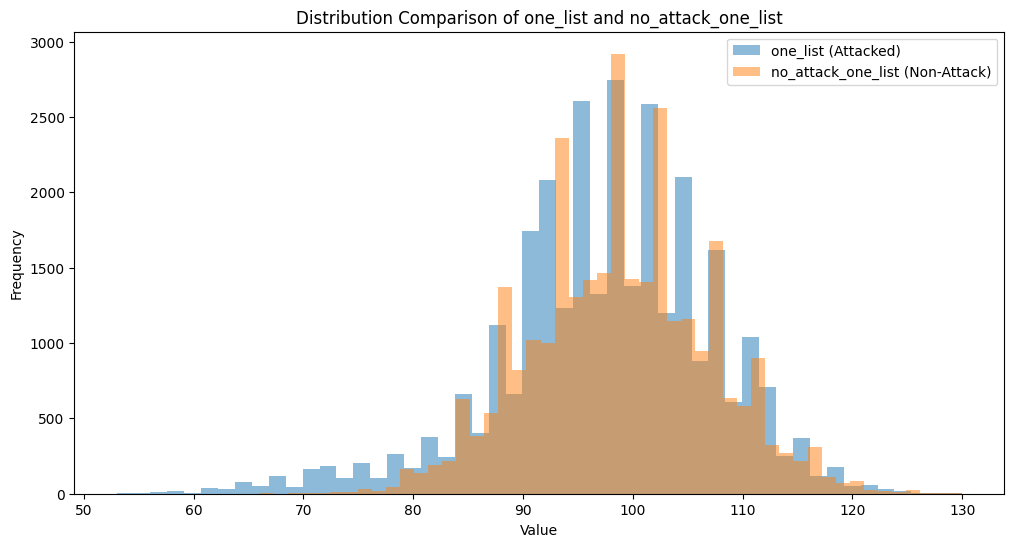

In [37]:
# Compare statistical measures
mean_one_list = np.mean(one_list)
std_one_list = np.std(one_list)
mean_no_attack_one_list = np.mean(no_attack_one_list)
std_no_attack_one_list = np.std(no_attack_one_list)

print(f'Comparison of one_list (Attacked) and no_attack_one_list (Non-Attack):')
print(f'  Mean of one_list: {mean_one_list:.2f}')
print(f'  Standard Deviation of one_list: {std_one_list:.2f}')
print(f'  Mean of no_attack_one_list: {mean_no_attack_one_list:.2f}')
print(f'  Standard Deviation of no_attack_one_list: {std_no_attack_one_list:.2f}')

# Visualize distributions
plt.figure(figsize=(12, 6))
plt.hist(one_list, bins=50, alpha=0.5, label='one_list (Attacked)')
plt.hist(no_attack_one_list, bins=50, alpha=0.5, label='no_attack_one_list (Non-Attack)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Comparison of one_list and no_attack_one_list')
plt.legend()
plt.show()

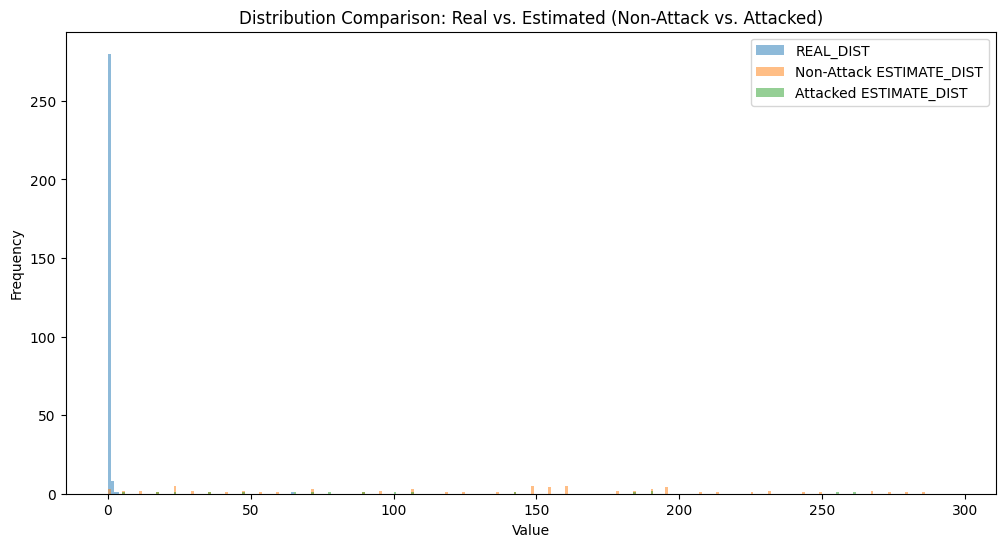

In [38]:
# Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(REAL_DIST, bins=range(domain + 1), alpha=0.5, label='REAL_DIST')
plt.hist(no_attack_ESTIMATE_DIST, bins=range(domain + 1), alpha=0.5, label='Non-Attack ESTIMATE_DIST')
plt.hist(ESTIMATE_DIST_Nattack, bins=range(domain + 1), alpha=0.5, label='Attacked ESTIMATE_DIST')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Comparison: Real vs. Estimated (Non-Attack vs. Attacked)')
plt.legend()
plt.show()